# Herron Topic 7 - Practice (Monday 2:45 PM, Section 3)

## Announcements

- Quiz 7 (our last quiz!) is due Friday, 4/14, at 11:59 PM
- Week of 4/17
    - I will record a lecture for Herron topic 5 on simulations and post a practice notebook
    - However, we will use class time for group work
    - This is a compromise between survey responses (1/3 wanted to drop simulations, 2/3 did not) and Monday's holiday (Patriot's Day)
- Week of 4/24
    - No lecture
    - We will use class time for group work
- Due dates
    - Project 2 at 11:59 PM on Wednesday, 4/26
    - Teammates review 2 at 11:59 PM on Wednesday, 4/26
    - 30,000 DataCamp XP at 11:59 PM on Friday, 4/28
- ***Please complete TRACE feedback on what topics, tools, and techniques you want more of***

## Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession()
import yfinance as yf
import pandas_datareader as pdr

In [4]:
mkt = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900',
        session=session
    )
    [0]
    .assign(
        R=lambda x: (x['Mkt-RF'] + x['RF']) / 100,
        logR=lambda x: np.log1p(x['R'])
    )
    [['R', 'logR']]
)

In [5]:
labels = {
    'R': 'Simple Return',
    'logR': 'Log Return'
}

### Repeat the comparison of log and simple returns with monthly and annual returns

We could download monthly and annual data from the Ken French data library.
However, we can also use the `.resample()` method to compound daily returns into monthly and annual returns.
Let us use the `.resample()` method (1) for practice and (2) because the `.resample()` code is simpler and more compact than the `pdr.DataReader()` code.
We need to re-calculate the log return.
We could instead sum the daily log returns, but combining the `.resample()` method with two different operations on two differ columns is complex and easily avoided here.

In [6]:
def totret(x):
    return (1 + x).prod() - 1

In [7]:
mkt_m = (
    mkt[['R']]
    .resample(rule='M', kind='period')
    .apply(totret)
    .assign(logR=lambda x: np.log1p(x['R']))
)

In [8]:
mkt_a = (
    mkt[['R']]
    .resample(rule='A', kind='period')
    .apply(totret)
    .assign(logR=lambda x: np.log1p(x['R']))
)

We want to repeat this plot for monthly and annual returns, so we can make out lives easier by writing a function.

In [9]:
def plot_compare_returns(x, freq, labs=labels):
    x.plot(x='R', y='logR', kind='scatter')
    plt.title(f'Comparison of {freq} Log and Simple Returns')
    plt.xlabel(labs['R'])
    plt.ylabel(labs['logR'])
    plt.show()

Log and simple returns are similar for small returns.
We almost always see small daily returns, which rarely exceed 10% in magnitude.
However, at monthly frequencies, we start to see large outliers, where the similarity of log and simple returns starts to break down.

Recall the `.pipe()` method allows us to think "data first".
Here `mkt_m.pipe(plot_compare_returns, freq='Monthly')` is the same as `plot_compare_returns(mkt_m, freq='Monthly')`.
One is not better than the other, but I find it useful to think "data, then operation, then operation, ...", instead of "operation, then operation, ..., then data".

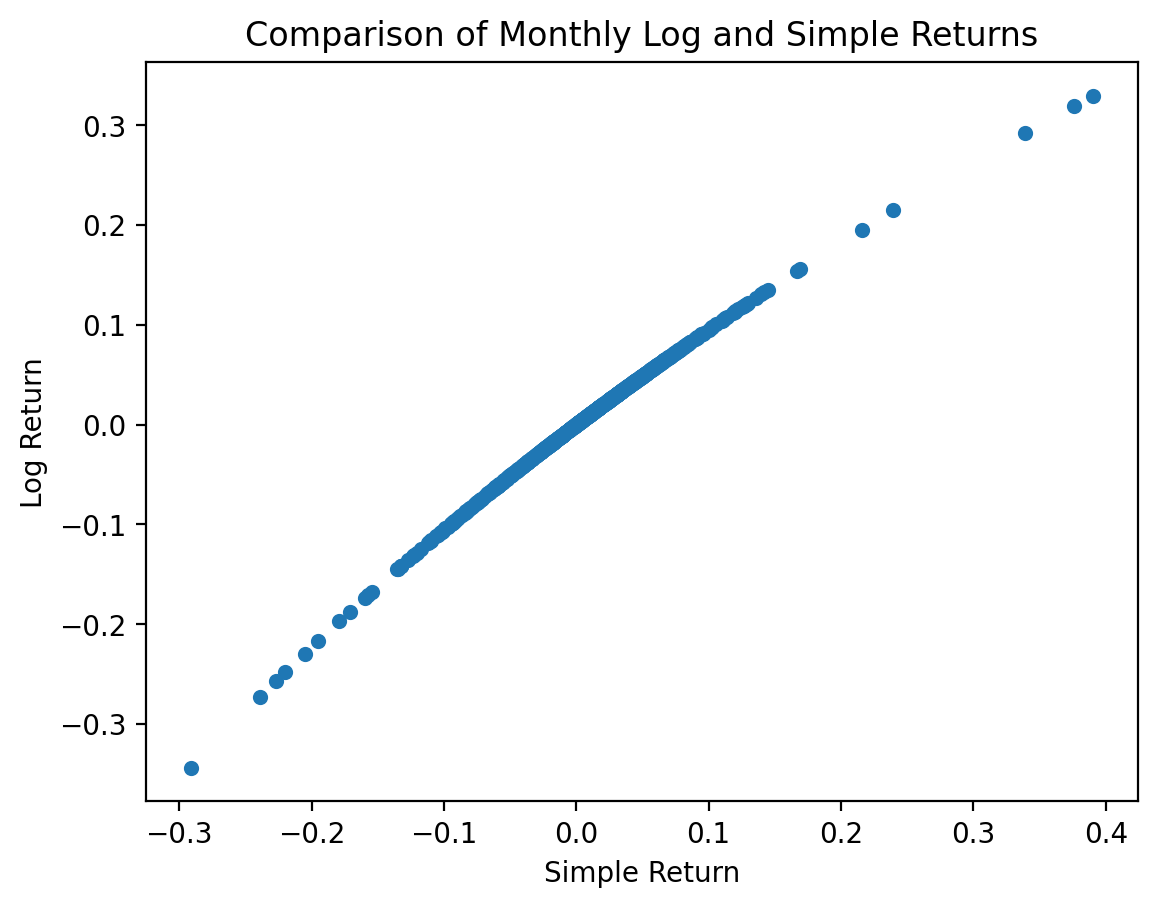

In [10]:
mkt_m.pipe(plot_compare_returns, freq='Monthly')

At annual frequencies, log and simple returns can be quite different!
For example, at $R_{simple} \approx 0.6$, we see $R_{log} \approx 0.4$.

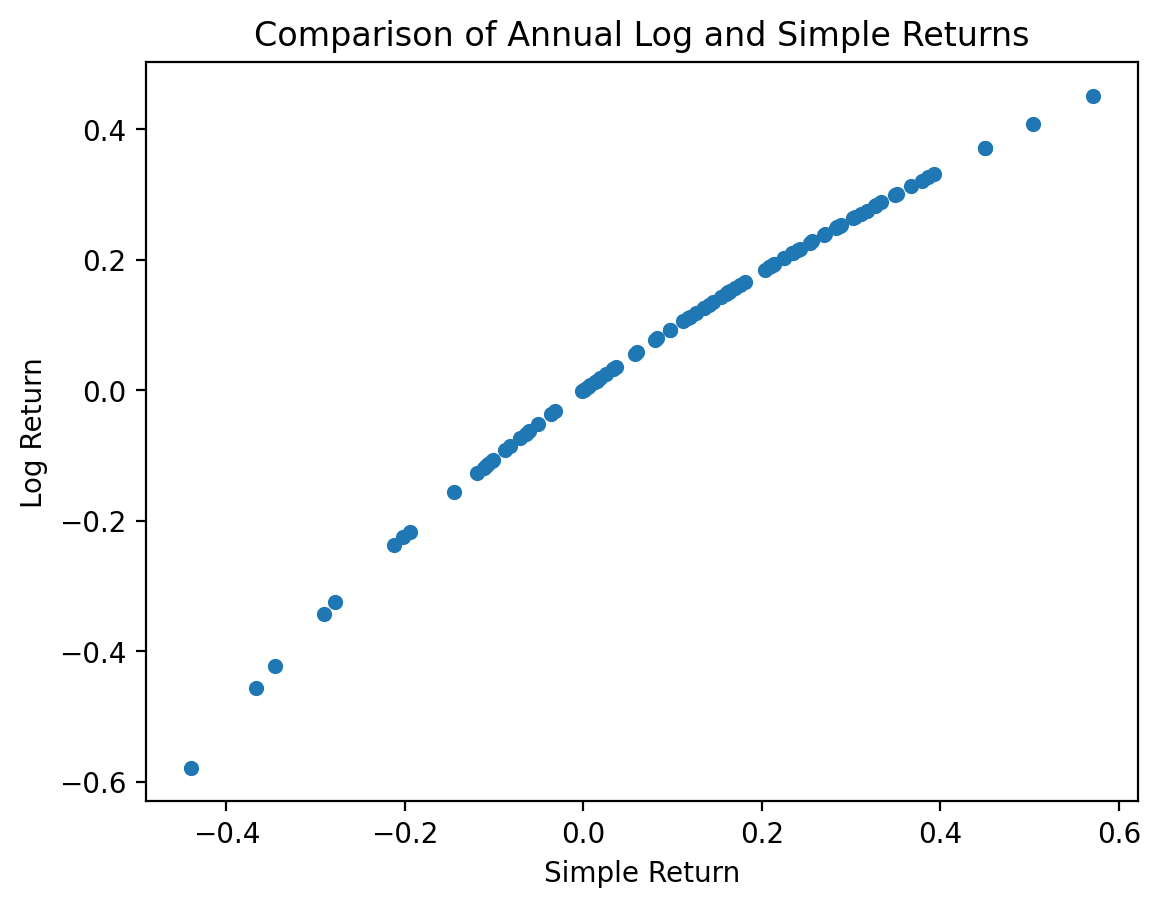

In [11]:
mkt_a.pipe(plot_compare_returns, freq='Annual')

### Repeat the autocorrelation plot with *monthly* returns instead of *daily* returns

Again, we will write a function to plot these autocorrelations.

### Plot monthly returns versus their one-month lag

In [12]:
def plot_autocorr(x, freq, n=10, labs=labels):
    x_lags = pd.concat(objs=[x['R'].shift(t) for t in range(n + 1)], axis=1)
    corrs = x_lags.corr().iloc[0]
    serrs = np.sqrt((1 - corrs**2) / (x_lags.count() - 2))

    plt.bar(height=corrs, x=range(n + 1), yerr=2*serrs)
    plt.title(
        f'Autocorrelation of {freq} Returns' +
        '\nBlack Vertical Bars Indicate Standard Errors'
    )
    plt.xlabel(f'{freq} Lag')
    plt.ylabel('Autocorrelation Coefficient')
    plt.show()

At the monthly horizon, return autocorrelation weakens!
All autocorrelation coefficient estimates are small and less than two standard errors away from zero.

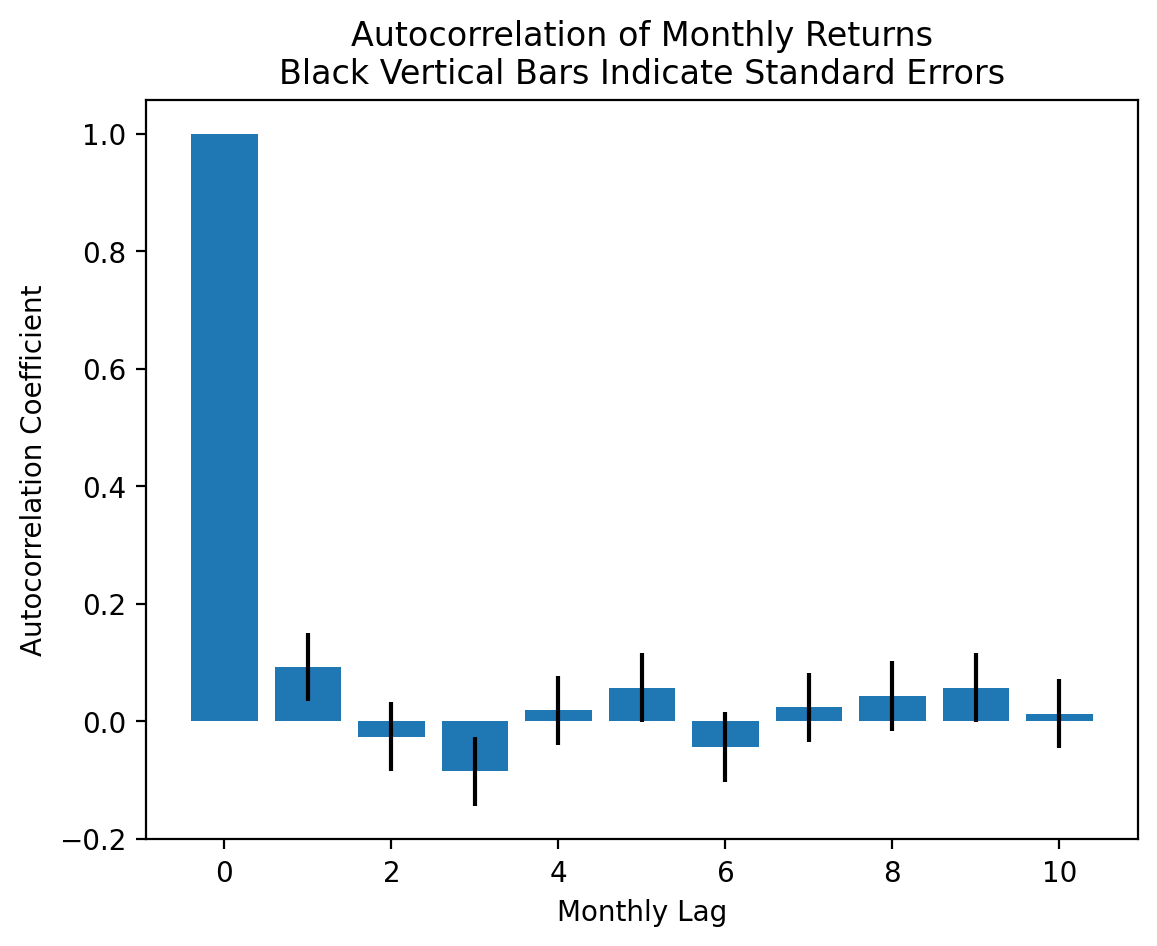

In [13]:
mkt_m.pipe(plot_autocorr, freq='Monthly')

At the annual horizon, return autocorrelation disappears!

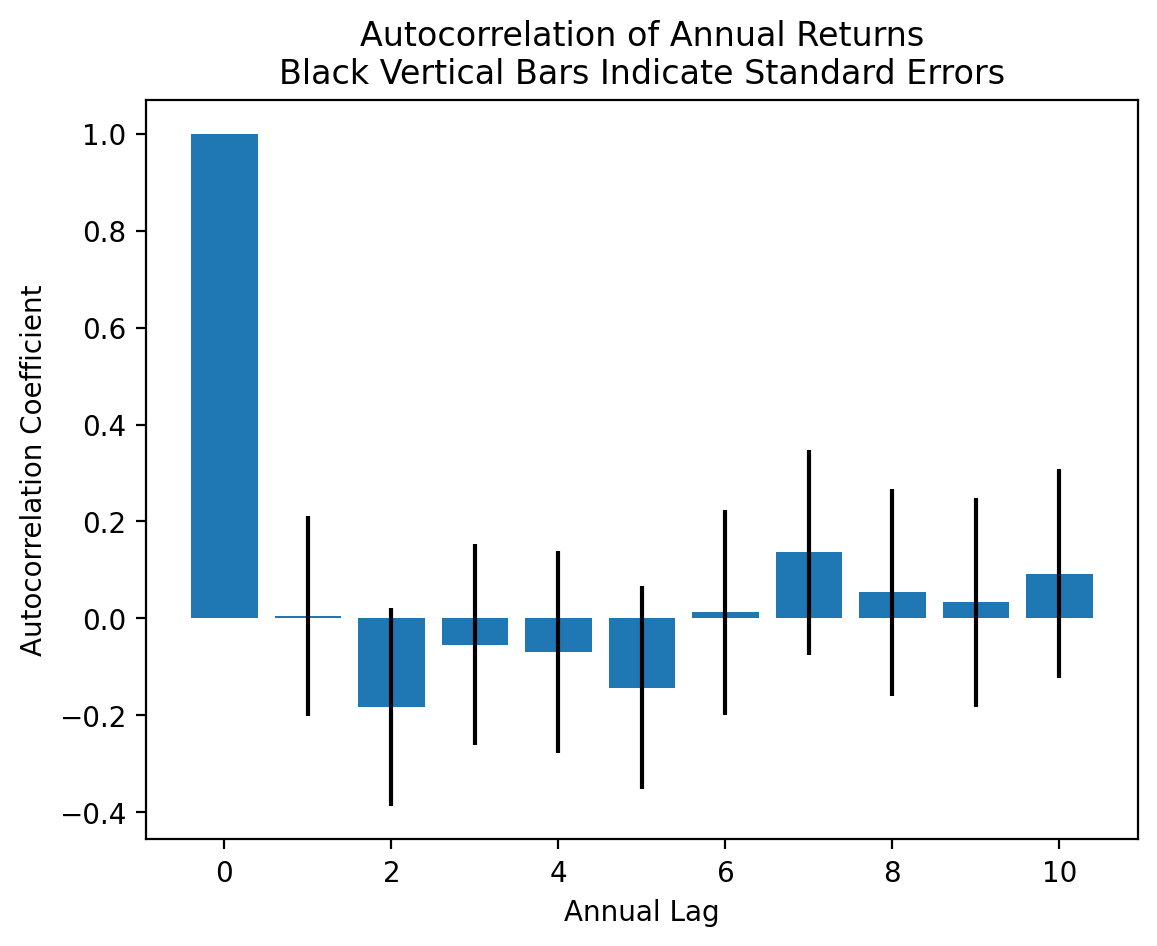

In [14]:
mkt_a.pipe(plot_autocorr, freq='Annual')

### Repeat the autocorrelation plot with the *absolute value* of daily returns

We can use our function again!
But first, we have to convert simple returns to the *absolute value* of simple returns.

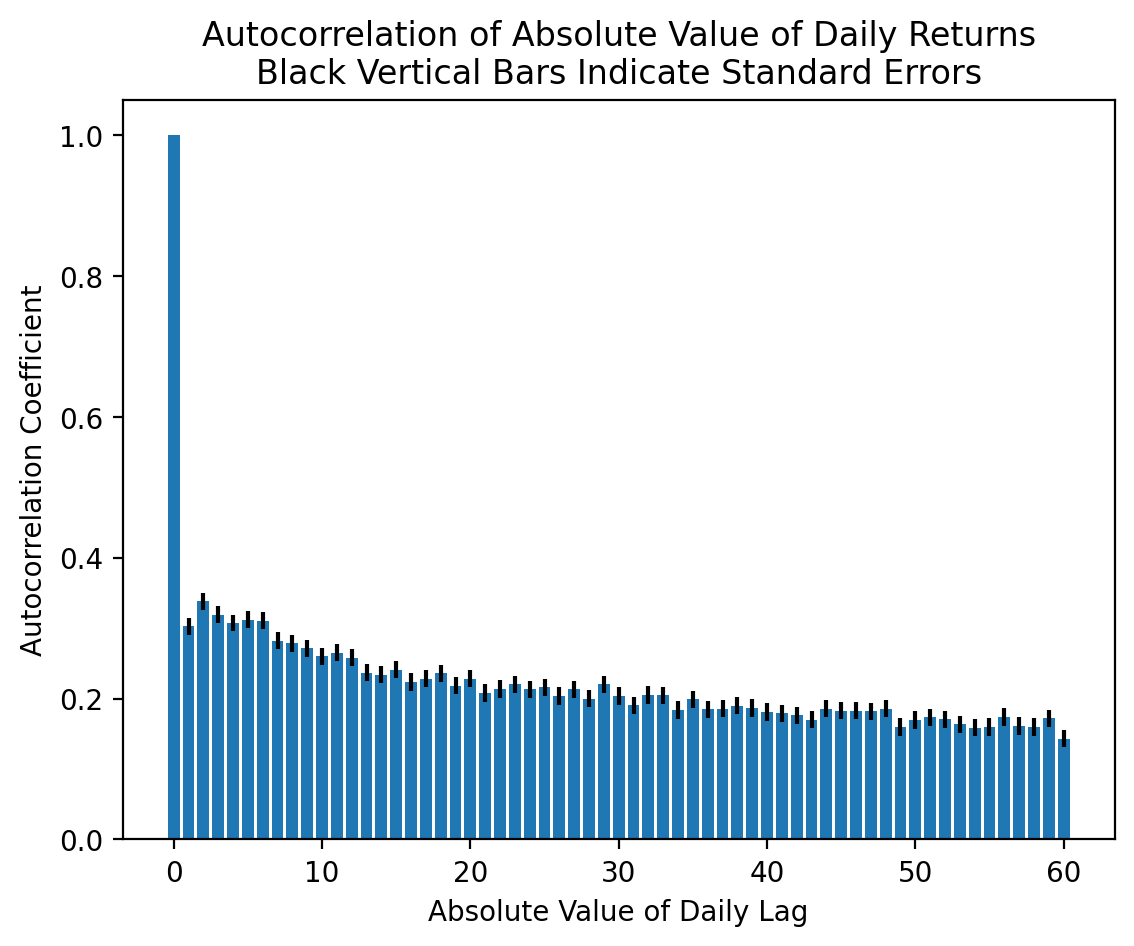

In [15]:
(
    mkt
    .assign(R=lambda x: x['R'].abs())
    .pipe(plot_autocorr, freq='Absolute Value of Daily', n=60)
)

Saying that "squared returns" or "the absolute value of returns" is autocorrelated is similar to saying "return magnitudes" are autocorrelated, which is similar to saying "volatility" is autocorrelated or persistent.

### Repeat the leverage effect plot with lagged returns

We will only make this plot, but we can still write a function!

In [16]:
import seaborn as sns

In [17]:
def plot_leverage_effect(x, rule, freq):
    (
        x['R']
        .resample(rule=rule, kind='period')
        .agg([totret, 'std'])
        .assign(totret_lag=lambda x: x['totret'].shift())
        .mul(100)
        .pipe(lambda x:
              sns.regplot(
                  x='totret_lag', 
                  y='std', 
                  data=x,
                  scatter_kws={'alpha': 0.1}
            )
        )
    )
    plt.xlabel(f'One-{freq} Lag of Total Return (%)')
    plt.ylabel('Volatility of Returns (%)')
    plt.suptitle(
        'Fisher Black\'s Leverage Effect\n' + 
        f'(Daily Returns Aggregated by {freq})'
    )
    plt.show()

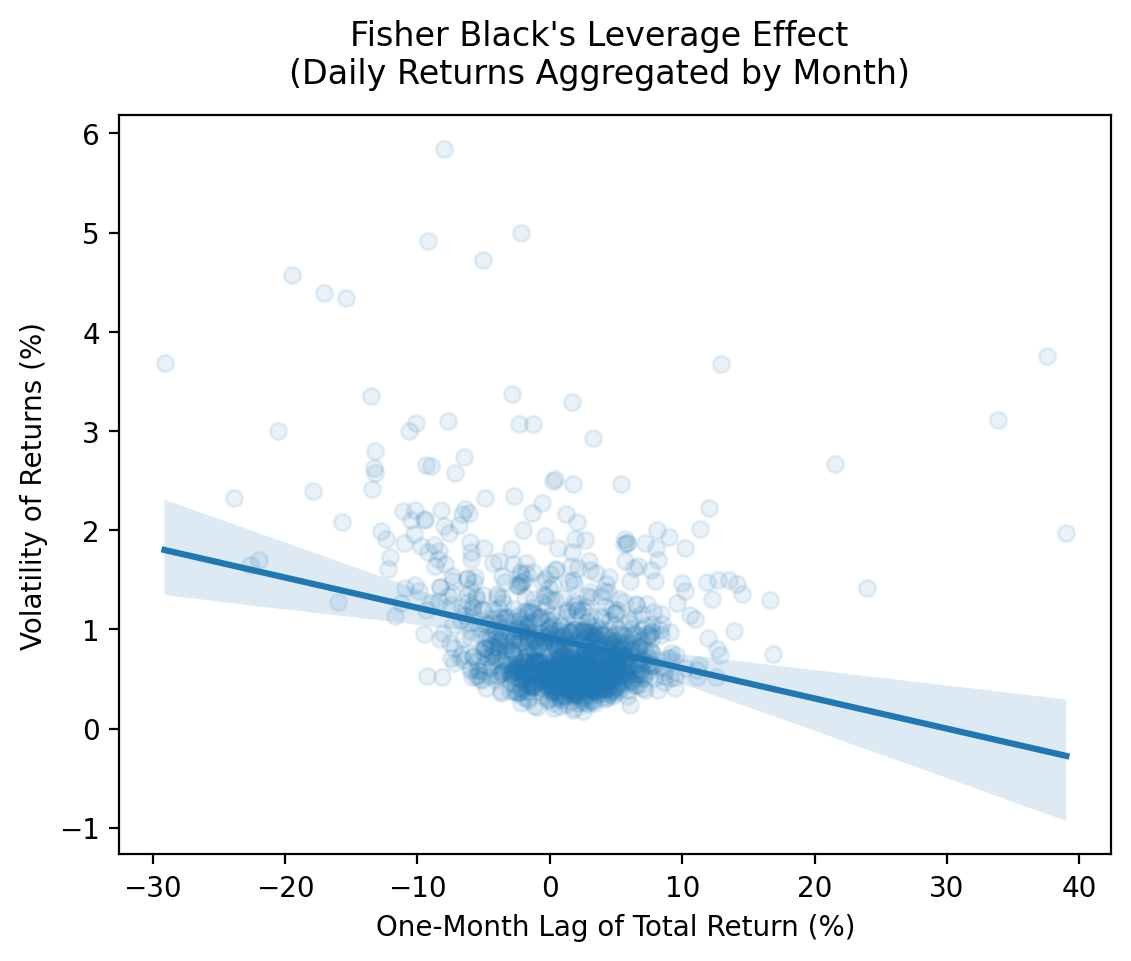

In [18]:
mkt.pipe(plot_leverage_effect, rule='M', freq='Month')

Since we have the function, let use a try a few different horizons!

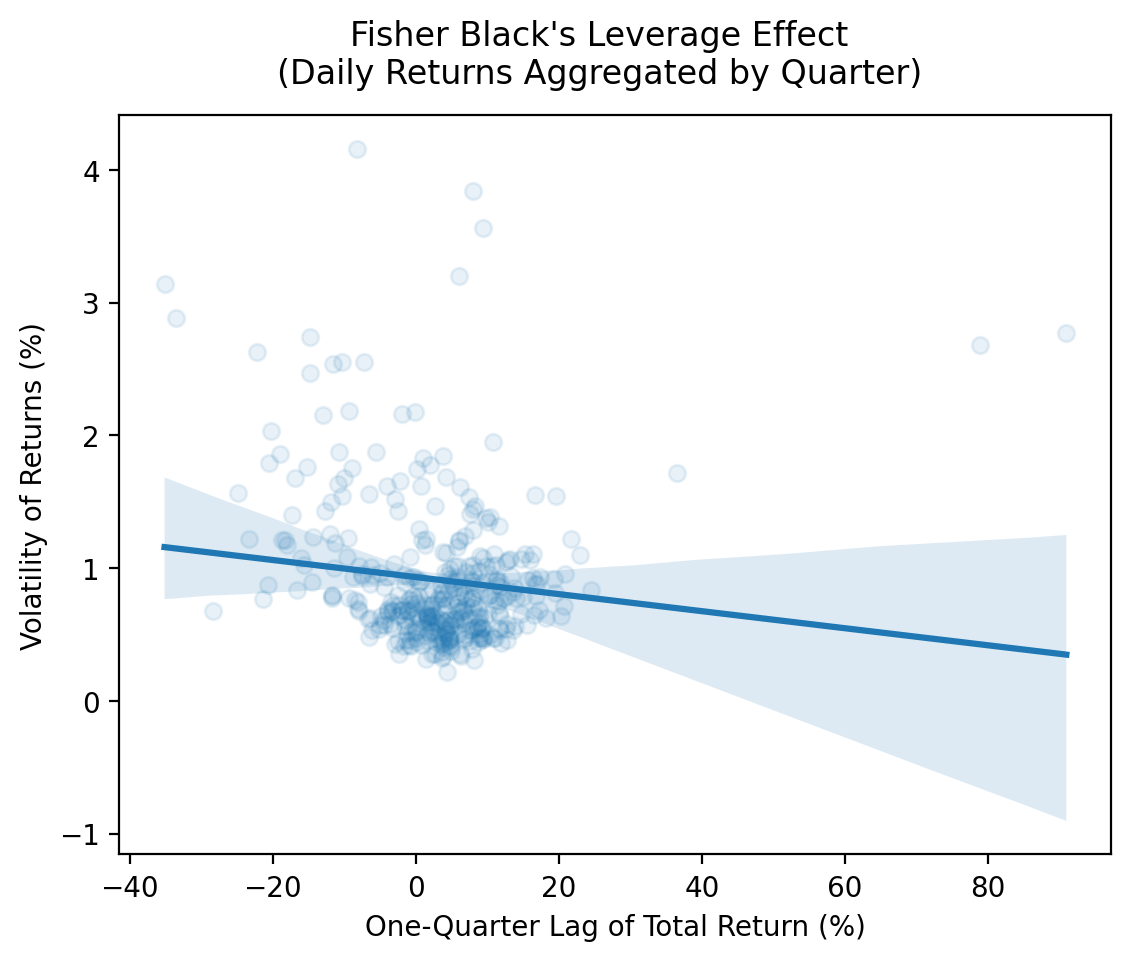

In [19]:
mkt.pipe(plot_leverage_effect, rule='Q', freq='Quarter')

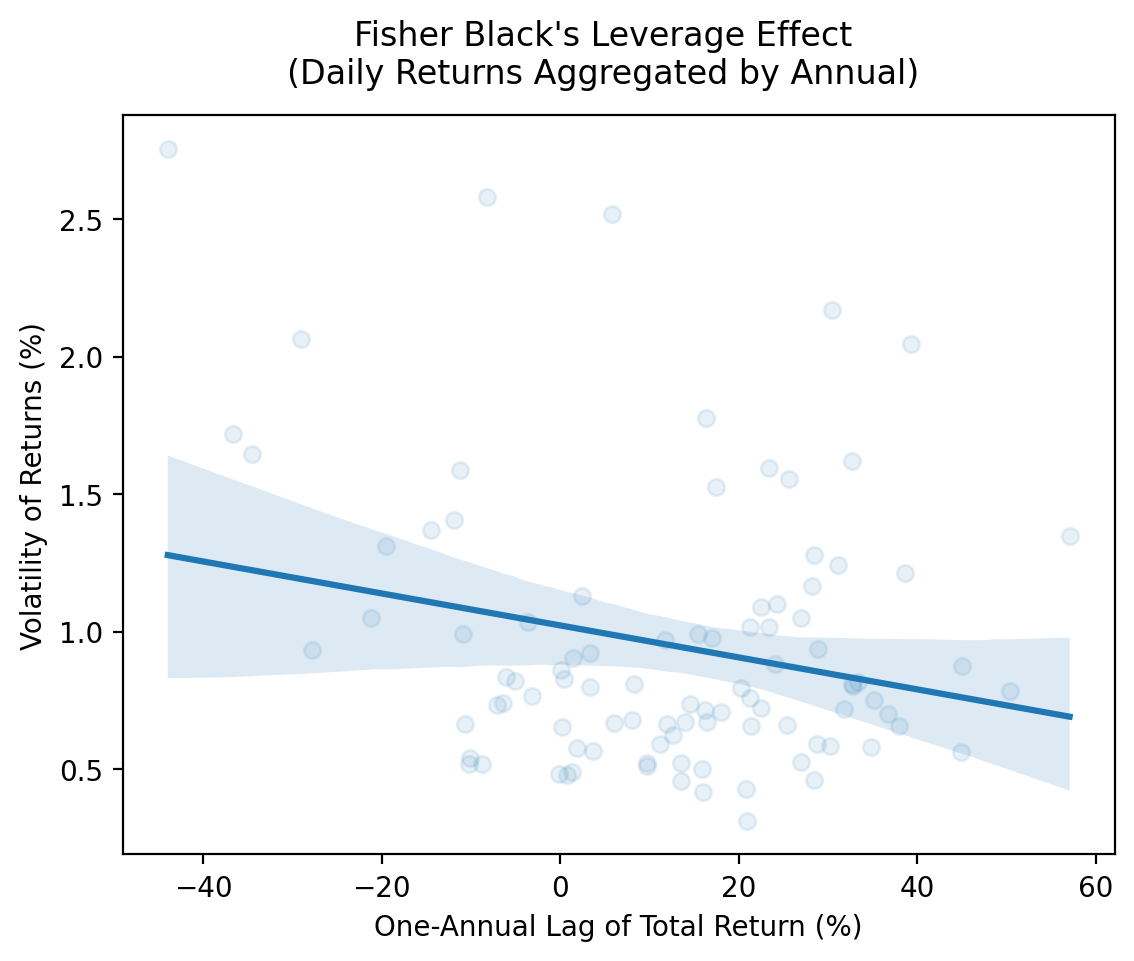

In [20]:
mkt.pipe(plot_leverage_effect, rule='A', freq='Annual')